#Desenvolvimento do modelo

Nessa parte, desenvolvemos o modelo, usando o modelo de RandomForest junto com oversampling. Primeiramente, importaremos todos os pacotes necessários:

In [2]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, make_scorer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.simplefilter(action='ignore', category=Warning)
from sklearn.pipeline import Pipeline
from sklearn import set_config
from sklearn.metrics import recall_score,make_scorer,accuracy_score,f1_score
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import KFold,cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from joblib import dump, load

Agora, importaremos o dataset limpo, para procedermos com o modelo

In [3]:
pd.set_option('display.max_columns', None)
telefonia_2 = pd.read_csv(r'C:\Users\Pedro\Desktop\Machine_Learning\Trabalho\Dataset_Limpo_Classi.csv')
telefonia_2.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,Contract_One year,Contract_Two year,InternetService_Fiber optic,InternetService_No,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,29.85,29.85,No,0,0,0,0,0,1,0
1,1,0,0,0,34,1,0,1,0,1,0,0,0,0,56.95,1889.50,No,1,0,0,0,0,0,1
2,1,0,0,0,2,1,0,1,1,0,0,0,0,1,53.85,108.15,Yes,0,0,0,0,0,0,1
3,1,0,0,0,45,0,0,1,0,1,1,0,0,0,42.30,1840.75,No,1,0,0,0,0,0,0
4,0,0,0,0,2,1,0,0,0,0,0,0,0,1,70.70,151.65,Yes,0,0,1,0,0,1,0


Observamos que há uma discrepância muito grande dos dados, como pode se notar abaixo, em que há muito mais casos de não desligamento do que de desligamento. 

<Axes: xlabel='Churn'>

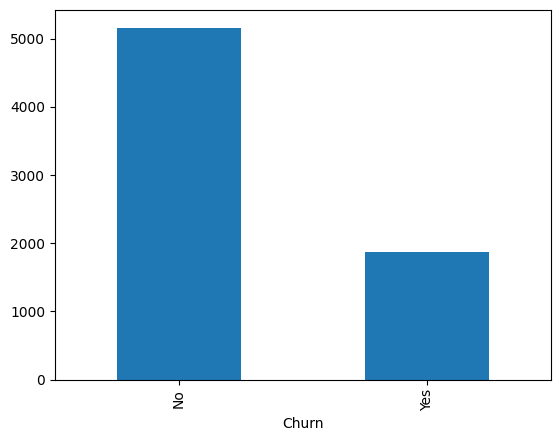

In [4]:
telefonia_2.pivot_table(index='Churn', aggfunc='size').plot(kind='bar')

In [5]:
X = telefonia_2.drop(columns=['Churn'],axis = 1)

y = telefonia_2['Churn']

X_train , X_test , y_train , y_test = train_test_split(X, y, test_size=0.20, stratify=y)

A fim de otimizar nosso modelo, usamos SelectKBest, a fim de selecionar as 17 colunas mais relevantes para a nossa análise. A principio, não queremos retirar as colunas dummies, por entender que isso causaria perda de informação.

In [6]:
select = SelectKBest(score_func=chi2, k=17)
z = select.fit_transform(X,y)


Verificamos quais as colunas são as colunas que iremos tirar.

In [7]:
filtered_columns = select.get_support()

In [8]:
filtered_columns

array([False,  True,  True,  True,  True, False, False,  True,  True,
       False,  True, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

Em seguida, seguimos com as colunas retiradas

In [9]:
X_limpo = X[X.columns[filtered_columns]]


Como podemos ver, as colunas retiradas foram 'Gender' e 'PhoneService'. Isso nos informa que o gênero ou se saber se o cliente usa serviço de telefone não influencia significativamente no nosso modelo.

In [10]:
X_limpo.head()

,SeniorCitizen,Partner,Dependents,tenure,OnlineSecurity,OnlineBackup,TechSupport,PaperlessBilling,MonthlyCharges,TotalCharges,Contract_One year,Contract_Two year,InternetService_Fiber optic,InternetService_No,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,0,1,0,1,0,1,29.85,29.85,0,0,0,0,0,1,0
1,0,0,0,34,1,0,0,0,56.95,1889.50,1,0,0,0,0,0,1
2,0,0,0,2,1,1,0,1,53.85,108.15,0,0,0,0,0,0,1
3,0,0,0,45,1,0,1,0,42.30,1840.75,1,0,0,0,0,0,0
4,0,0,0,2,0,0,0,1,70.70,151.65,0,0,1,0,0,1,0


In [11]:
X_train , X_test , y_train , y_test = train_test_split(X_limpo, y, test_size=0.20, stratify=y)

Agora, criamos um pipeline com o nosso modelo. Introduzimos o Smote no inicio, seguido de uma normalização, para depois aplicar o RandomForest. Os parâmetros a seguir foram otimizados para que o modelo tenha o melhor recall.

In [ ]:
lista_etapas = [('smote', SMOTE()),
                ("std_scaler", StandardScaler()), 
                ("rf", RandomForestClassifier(n_estimators=3, \
                                                   max_depth=5, \
                                                   random_state=42, \
                                                   n_jobs=-1))]

pipe_rf = imbpipeline(lista_etapas)


splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

metrica = make_scorer(recall_score,pos_label ='Yes')

param_grid = {"rf__n_estimators" : range(150,200,10),
              "rf__max_depth" : range(4, 8),
              "rf__max_features" : range(2, 4)}



A seguir, o nosso modelo de GridSearch, a fim de treinar o nosso modelo.

In [ ]:
grid_rf_smote = GridSearchCV(estimator=pipe_rf, 
                        param_grid=param_grid,
                        scoring=metrica,
                        cv=splitter,
                        verbose=10)

In [ ]:
grid_rf_smote.fit(X_train,y_train)


Fitting 10 folds for each of 40 candidates, totalling 400 fits
[CV 1/10; 1/40] START rf__max_depth=4, rf__max_features=2, rf__n_estimators=150.
[CV 1/10; 1/40] END rf__max_depth=4, rf__max_features=2, rf__n_estimators=150;, score=0.767 total time=   4.7s
[CV 2/10; 1/40] START rf__max_depth=4, rf__max_features=2, rf__n_estimators=150.
[CV 2/10; 1/40] END rf__max_depth=4, rf__max_features=2, rf__n_estimators=150;, score=0.713 total time=   0.4s
[CV 3/10; 1/40] START rf__max_depth=4, rf__max_features=2, rf__n_estimators=150.
[CV 3/10; 1/40] END rf__max_depth=4, rf__max_features=2, rf__n_estimators=150;, score=0.733 total time=   0.3s
[CV 4/10; 1/40] START rf__max_depth=4, rf__max_features=2, rf__n_estimators=150.
[CV 4/10; 1/40] END rf__max_depth=4, rf__max_features=2, rf__n_estimators=150;, score=0.760 total time=   0.3s
[CV 5/10; 1/40] START rf__max_depth=4, rf__max_features=2, rf__n_estimators=150.
[CV 5/10; 1/40] END rf__max_depth=4, rf__max_features=2, rf__n_estimators=150;, score=0.

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('smote', SMOTE()),
                                       ('std_scaler', StandardScaler()),
                                       ('rf',
                                        RandomForestClassifier(max_depth=5,
                                                               n_estimators=3,
                                                               n_jobs=-1,
                                                               random_state=42))]),
             param_grid={'rf__max_depth': range(4, 8),
                         'rf__max_features': range(2, 4),
                         'rf__n_estimators': range(150, 200, 10)},
             scoring=make_scorer(recall_score, pos_label=Yes), verbose=10)

A seguir, os melhores parâmtros.

In [ ]:
grid_rf_smote.best_params_

{'rf__max_depth': 5, 'rf__max_features': 3, 'rf__n_estimators': 180}

Vamos predizer nosso modelo, a fim de testa-lo.

In [ ]:
y_pred = grid_rf_smote.predict(X_test)

Agora, vemos que nosso recall é de 73% para o caso de saída.

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

          No       0.89      0.77      0.83      1033
         Yes       0.54      0.73      0.62       374

    accuracy                           0.76      1407
   macro avg       0.71      0.75      0.72      1407
weighted avg       0.79      0.76      0.77      1407



[[779 254]
 [ 80 294]]


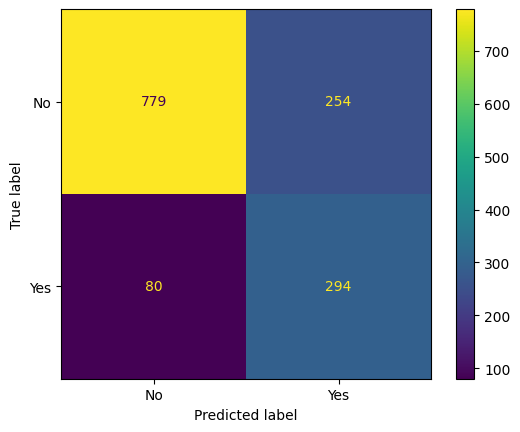

In [ ]:
print(confusion_matrix(y_test, y_pred))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

Então, salvamos o nosso modelo.

In [ ]:

dump(grid_rf_smote, 'modelo_final_com_selectK.joblib')



['modelo_final_com_selectK.joblib']

In [ ]:
dtr_load = load(r"C:\Users\Pedro\Desktop\Machine_Learning\Trabalho\Smote\segundo_modelo_treinado_smote.joblib")

Para validar se o modelo é viável ou não deve ser feito um estudo financeiro para ver se o gasto que teremos com os falsos Positivos é compensado pelos Verdadeiros Positivos